In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from functions_ import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [2]:
## reload the evaluation functions
from importlib import reload 
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *

In [176]:
### define the necessary variables

base_dir = os.getcwd() 

catch_left = ''
catch_right = ''

Barcodes = {"BC1_fwd": "CCC", 
            "BC1_rev" : "CCC", 
            "BC2_fwd":	"AAA",
            "BC2_rev":	"AAA", 
            "BC3_fwd":	"TTT",
            "BC3_rev":	"TTT",}

Primer_seq = {"_fwd": "cgccgCATGGAAGCGAT".upper(),
              "_rev":"cgcacgCGGTTATCCATCG".upper()}

Primer_out_of_triplets = {"_fwd": 0, 
                          "_rev": 2}
amplicon_seq = "cgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcg".upper()

amplicon_AA = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [185]:
variant = "R36"
BCs_per_var = {"R35": ["BC1", "BC2"],
               "R36": ["BC1", "BC2", "BC3"],
               }

In [186]:

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
ref_gene = amplicon_seq

used_BCs = BCs_per_var[variant]

filter_for_n_mut = False# True
read_len_treshold = None#(40,40)

## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities, base_dir = f"{os.getcwd()}/data/fastq/{variant}"
)

all_reads, all_ids = demultiplex_reads(a_seq, b_seq, ref_gene = ref_gene ,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = used_BCs, Sections = [""], max_mismatch_primerseq = 5, filter_for_n_mut = filter_for_n_mut, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= read_len_treshold, Primer_out_of_triplets= Primer_out_of_triplets, cut_primer_start=True, cut_BC_seq=True)


#### settings
amplicon_DNA = amplicon_seq[:-2]
amplicon_AA = translate_dna2aa(amplicon_DNA)

### set parameters
base_dir = os.getcwd()
name = variant
FigFolder =f"{base_dir}/output/{name}/R1-R2"
use_rev_read = True
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False

if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

total reads 85274
[3, 5, 6, 11, 12, 14, 18, 20, 23, 24]
41699
2324 b reads are empty
702 a reads are empty
34446 forward reads with matching BC and primer seq
15012 reads with index swapping
BC1  34446 reads before filtering
################# Done: BC1 
################# Done: BC1
[0, 1, 2, 4, 7, 8, 9, 10, 15, 17]
26509
1951 b reads are empty
209 a reads are empty
21158 forward reads with matching BC and primer seq
13269 reads with index swapping
BC2  21158 reads before filtering
################# Done: BC2 
################# Done: BC2
[13, 16, 19, 21, 22, 31, 41, 44, 56, 71]
11759
852 b reads are empty
85 a reads are empty
8452 forward reads with matching BC and primer seq
7610 reads with index swapping
BC3  8452 reads before filtering
################# Done: BC3 
################# Done: BC3


In [ ]:
# Bc = "BC3"
# Read_dir = "R2"
# seqs = all_reads[f"{Bc}__{Read_dir}"]
# reads = all_reads[f"{Bc}__{Read_dir}"] if Read_dir == "R1" else [dna_rev_comp(r) for r in all_reads[f"{Bc}__{Read_dir}"]]

# output_file = f"data/fastq/{variant}/{variant}_{Bc}_Nt_filt_{Read_dir}_001.fasta"
# sequences = [SeqIO.SeqRecord(Seq(read), id = all_ids[f"{Bc}__{Read_dir}"][i], description = f"{variant} {Bc} DNA sequence") for i, read in enumerate(reads)]

# count = SeqIO.write(sequences, output_file, "fasta")
# with open(output_file, "w") as output_handle:
#     SeqIO.write(sequences, output_handle, "fasta")
# print("Saved %i records to %s" % (count, output_file))

In [187]:
same_bc = 0
diff_bc = 0
for idx, a_read in enumerate(a_seq): 
    if a_read[:3] == b_seq[idx][:3] and a_read[:3] != "":
        same_bc += 1  
    else: 
        diff_bc += 1
        
print("same BC: ", same_bc)
print("idx swapping BC: ", diff_bc)
print(diff_bc/(same_bc+diff_bc), " of reads have swapped BCs") #0.23862062377609017 0.24850481975748762

same BC:  64083
idx swapping BC:  21191
0.24850481975748762  of reads have swapped BCs


In [218]:
a_seq = all_reads["BC1__R1"]
b_seq = all_reads["BC1__R2"]

In [219]:
data_type = "DNA"
dataType_handler = {"DNA": gather_nt_variants, "Codons": gather_codon_variants, "AA": gather_AA_variants}
gather_variants = dataType_handler.get(data_type)

ref_seq = amplicon_DNA if data_type != "AA" else amplicon_AA

variants = pd.DataFrame.from_dict(gather_variants(a_seq = a_seq, b_seq = b_seq, ref = ref_seq))
variants_counts, variants_prop = mask_ref_in_variants_df(variants, ref_seq = ref_seq, data_type=data_type)

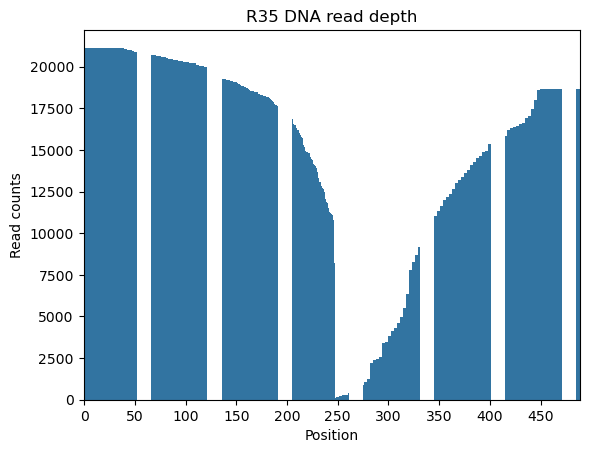

In [220]:
coverage_plot(variants.sum(), FigFolder=FigFolder, samplename=name+ " DNA")

In [221]:
### look specifically at reads with S->L mutation at pos 9 (these reads most likely do not have LOV2 inserted)
LOVstart_idx = amplicon_AA.index("SGLATTLER")
LOVend_idx = len(amplicon_AA) - amplicon_AA.index("DEAAKG") - len("DEAAKG")+1
aa_seqs = [translate_dna2aa(a[len(catch_left):]) if len(a) > len(catch_left) else "" for a in a_seq]
aa_idxs_oi = [a[LOVstart_idx:LOVstart_idx+2] =="LH" if len(a) > LOVstart_idx+1 else False  for a in aa_seqs]
print(sum(aa_idxs_oi), " a reads without LOV2")

aa_seqs_oi = [a for idx, a in enumerate(a_seq) if aa_idxs_oi[idx]]
print(Counter([translate_dna2aa(seq[len(catch_left):]) for seq in aa_seqs_oi]))
### these reads show, that LOV2 is missing (where it should be inserted, the AraC sequence proceeds instead of the LOV2 sequence occuring)

### same for b reads
### look specifically at reads with G->E mutation at pos 9 (these reads most likely do not have LOV2 inserted)
b_aa_seqs = [translate_dna2aa(dna_rev_comp(b[len(catch_right):len(catch_right)+(len(b)-len(catch_right))//3*3]))if len(b) > len(catch_right) else "" for b in b_seq]
b_seqaa_idxs_oi = [b[-LOVend_idx-1:-LOVend_idx+1] =="NE" if len(b) > LOVend_idx else False  for b in b_aa_seqs]
print(sum(b_seqaa_idxs_oi), " b reads without LOV2")

b_aa_seqs_oi = [b for idx, b in enumerate(b_seq) if b_seqaa_idxs_oi[idx]]
print(Counter([translate_dna2aa(dna_rev_comp(seq[len(catch_right):len(catch_right)+(len(seq)-len(catch_right))//3*3])) for seq in b_aa_seqs_oi]))

### exclude these reads 
a_seq = [a for idx, a in enumerate(a_seq) if not aa_idxs_oi[idx]]
b_seq = [b for idx, b in enumerate(b_seq) if not b_seqaa_idxs_oi[idx]]

## recalculate the mut enrichment
seq_variants = {}
seq_variants["AA"] = pd.DataFrame.from_dict(gather_AA_variants(a_seq, b_seq, ref = amplicon_AA, catch_left=catch_left, catch_right=catch_right, use_rev_read=use_rev_read))
if not use_forward_read or not use_rev_read: 
    seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
    
seq_variants["Codons"] = pd.DataFrame.from_dict(gather_codon_variants(a_seq, b_seq, ref = amplicon_DNA, catch_left=catch_left, catch_right=catch_right, use_rev_read=use_rev_read))
if not use_forward_read or not use_rev_read: 
    seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

seq_variants["DNA"] = pd.DataFrame.from_dict(gather_nt_variants(a_seq, b_seq, ref = amplicon_DNA, catch_left=catch_left, catch_right=catch_right, use_rev_read=use_rev_read))
if not use_forward_read or not use_rev_read: 
    seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]

36  a reads without LOV2
Counter({'RRMEAINESLHPP': 36})
106  b reads without LOV2
Counter({'MEAINESLHPPMDNRV': 50, 'AINESLHPPMDNRV': 35, 'EAINESLHPPMDNRV': 17, 'INESLHPPMDNRV': 3, 'TINESLHPPMDNRV': 1})


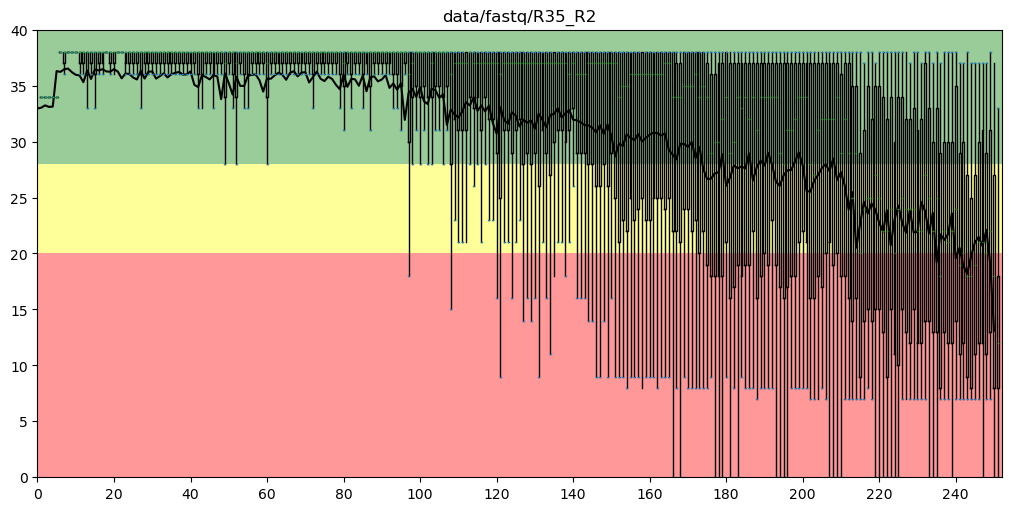

In [214]:
### the code was taken and adapted from ... ####

read_direction = "R2"

fig, axs = plt.subplots(1, 1, figsize=(10, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
filename = f"data/fastq/{variant}_{read_direction}_001.fastq"

fastq_parser = SeqIO.parse(filename, "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))

ax.set_xlim((0,l))
ax.set_ylim((0,40))
ax.set_title(filename.split(".")[0][:-4])
plt.savefig(f"{FigFolder}/{read_direction}_quality_scores.pdf", bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>

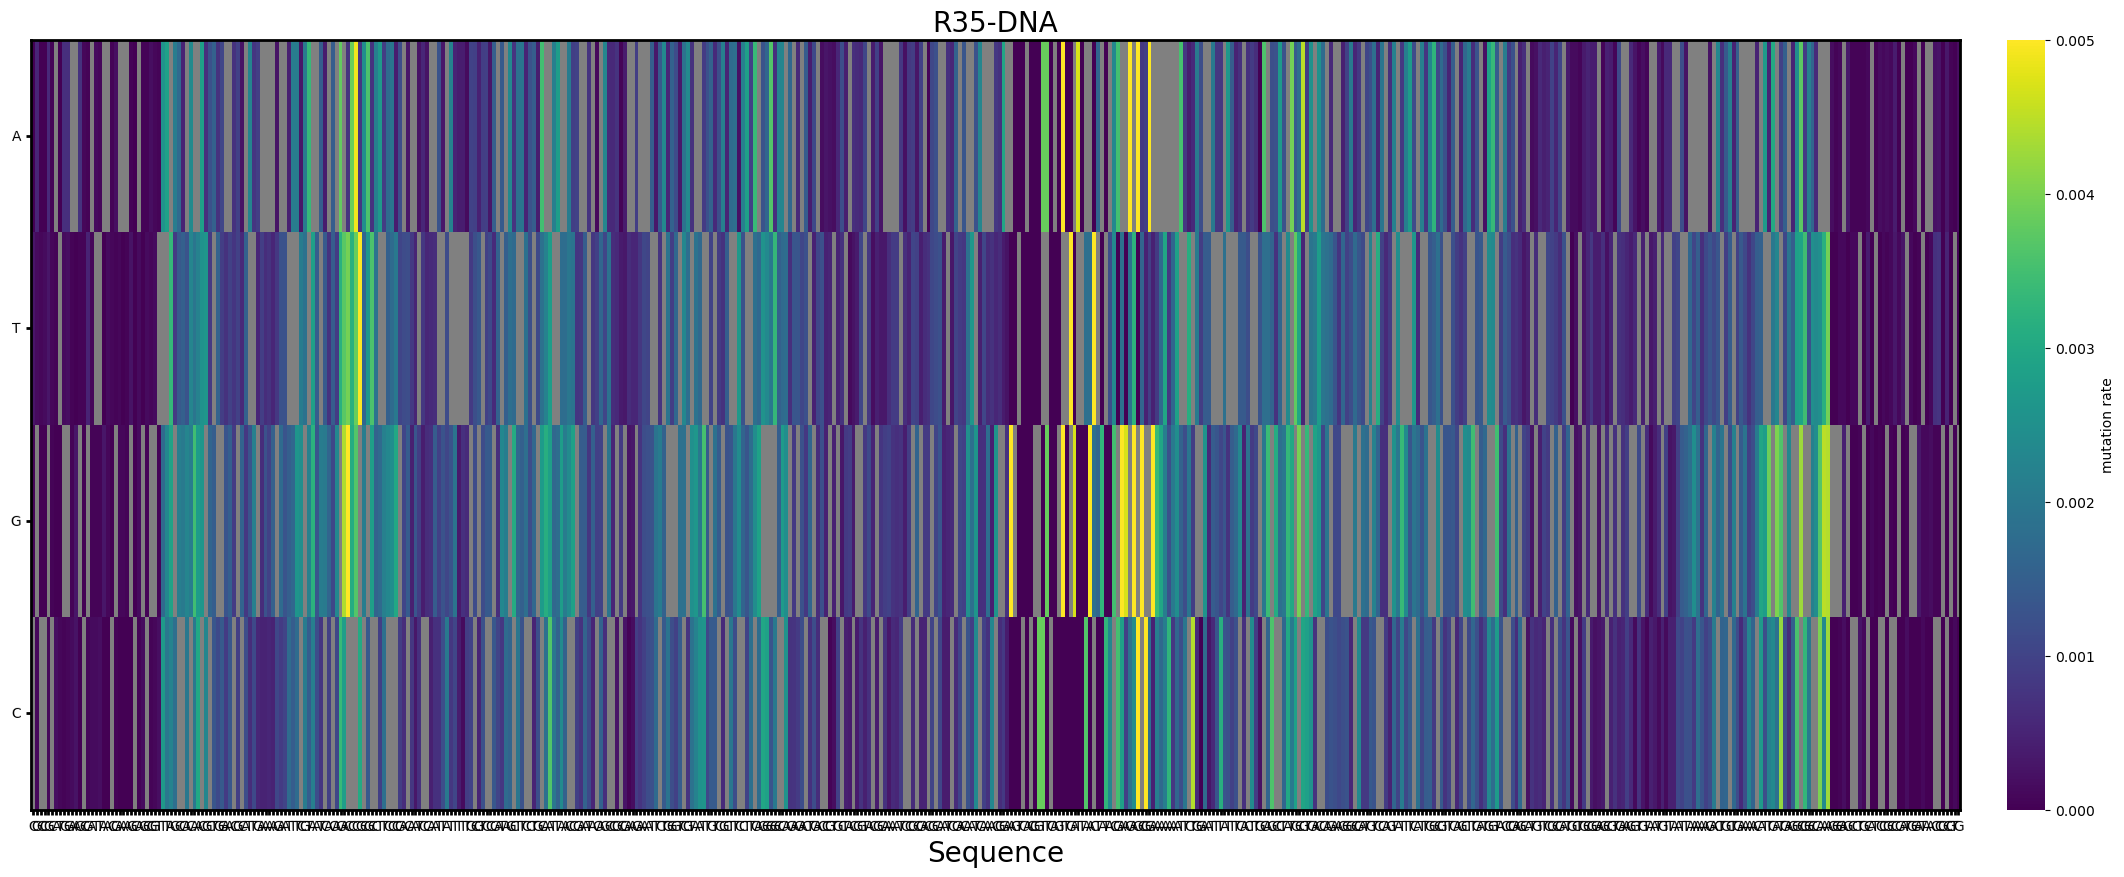

<Figure size 640x480 with 0 Axes>

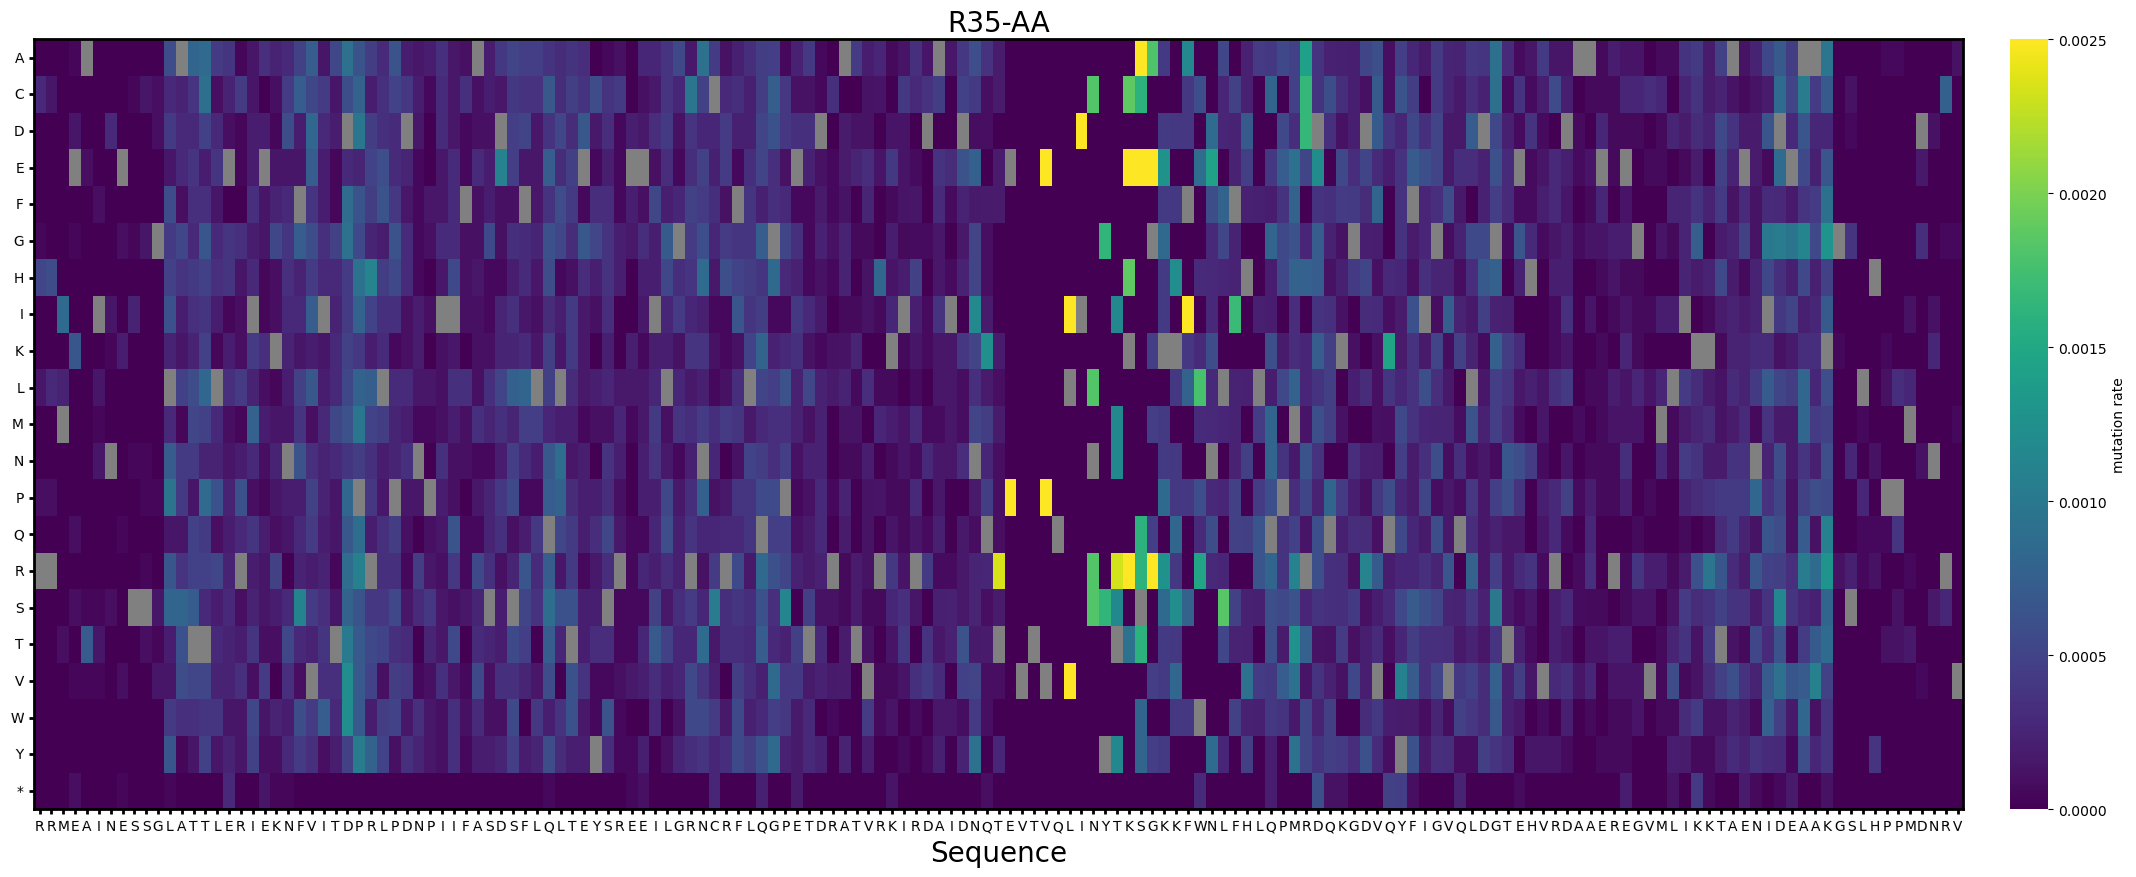

<Figure size 640x480 with 0 Axes>

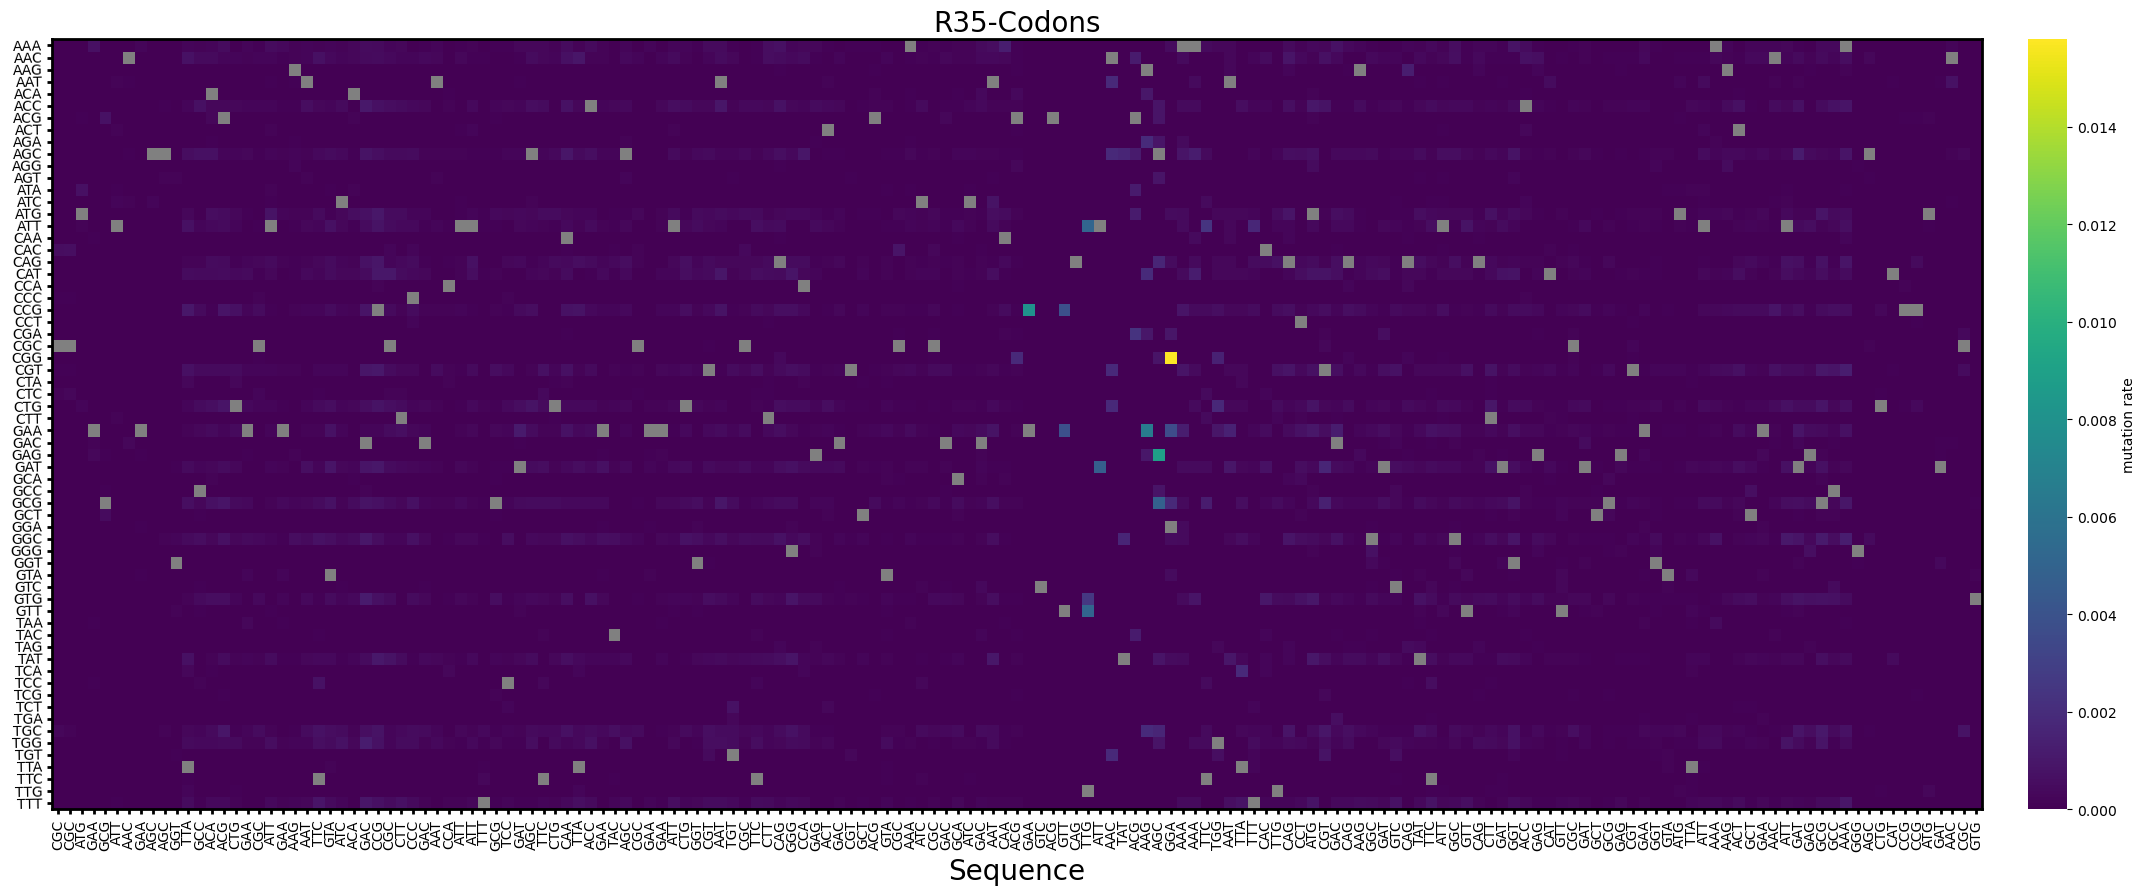

In [223]:
## plot mutation enrichment on DNA, AA and Codon level 
vmax = 0.0025
DNA_counts, DNA_relative = mask_ref_in_variants_df(seq_variants["DNA"], amplicon_DNA,data_type="DNA", reverse = not use_forward_read)
# if not use_forward_read: 
#     DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(variants_df=DNA_relative, samplename =  f'{name}-DNA', data_type = "DNA", ref_seq=amplicon_DNA[:DNA_relative.shape[1]], FigFolder=FigFolder, vmax = vmax*2)

AA_counts, AA_relative = mask_ref_in_variants_df(seq_variants["AA"], amplicon_AA,data_type="AA", reverse = not use_forward_read)
plot_mutation_enrichment(variants_df=AA_relative, samplename=f'{name}-AA',ref_seq=amplicon_AA[:AA_relative.shape[1]],data_type = "AA", FigFolder=FigFolder, vmax = vmax)


# AA_counts, AA_relative = mask_ref_in_variants_df(seq_variants["AA"], amplicon_AA,data_type="AA", reverse = not use_forward_read)
# plot_mutation_enrichment(variants_df=AA_relative, samplename=f'{name}-AA',ref_seq=amplicon_AA[:AA_relative.shape[1]],data_type = "AA", FigFolder=FigFolder, vmax = vmax)


Codons_counts, Codons_relative = mask_ref_in_variants_df(seq_variants["Codons"], amplicon_DNA,data_type="Codons", reverse = not use_forward_read)
# if not use_forward_read:
#     Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(variants_df=Codons_relative, samplename=f'{name}-Codons',ref_seq=amplicon_DNA[:DNA_relative.shape[1]],data_type = "Codons",  FigFolder=FigFolder, vmax=None)


In [163]:
import json

Bc = "BC2"
read_dir = "R1"
variant = "R35"

# Open the JSON file and load it as a dictionary
with open(f"data/blastoutput/{variant}_{Bc}_Nt_filt_{read_dir}_001.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>


blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "ggcggccaaa".upper()


LOV2_startidx = amplicon_seq.index(LOV_startseq)
LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)



<class 'dict'>


In [164]:
### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

#strand = blast_alignments[0]["hsps"][0]["hit_strand"] # "Minus" or "Plus"
filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


32368 alignments before filtering for LOV2 insertion site
27784 alignments after filtering for LOV2 insertion site


In [165]:
linker_alignments = {}
LOV2_alignments = {}
LOV2_start_indel_count = 0


for alignment in blast_alignments:
    qseq = alignment["hsps"][0]["qseq"].upper()
    hseq = alignment["hsps"][0]["hseq"].upper()
    seq_id = alignment["description"][0]["title"]
    midline = alignment["hsps"][0]["midline"]

    cut_site = qseq.find(LOV_startseq) if read_dir=="R1" else qseq.find(LOV_endseq) ## find LOV2 position, we add len(LOV_endseq) if "Minus" later, so that we can filter for reads that not conain the seq of interest due to insertions at these sites
    if cut_site != -1: ## if -1, there are insertions in start of LOV2, thus seq not in ref seq and we do not include these seq
        
        if read_dir=="R2":
            cut_site += len(LOV_endseq)

            read_out_of_frame = cut_site % 3  ## correct for out of frame reads, due to different lengths of our reads (only for R2, since R1 is always in frame, begin of the read is cut, but for R2, the end of the read is cut)
            
            linker_alignments[seq_id] = {"qseq": qseq[cut_site:], "hseq": hseq[cut_site:], "midline": midline[cut_site:]}
            LOV2_alignments[seq_id] = {"qseq": qseq[read_out_of_frame:cut_site], "hseq": hseq[read_out_of_frame:cut_site], "midline": midline[read_out_of_frame:cut_site]}

        else:    
            linker_alignments[seq_id] = {"qseq": qseq[:cut_site], "hseq": hseq[:cut_site], "midline": midline[:cut_site]}
            LOV2_alignments[seq_id] = {"qseq": qseq[cut_site:], "hseq": hseq[cut_site:], "midline": midline[cut_site:]}
    else:
        LOV2_start_indel_count +=1

print(LOV2_start_indel_count, "sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)")
    
    

28 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)


In [166]:
def translate_dna2aa(orf: str) -> str:
  """
  Ignorant DNA to protein translation.
  Stops on anything not from the genetic code and does not check for length.
  """
  protein = ''
  # Interestingly enough timing revealed that bad practices (loops and string addition)
  # resulted in the fastest translation (for a 150 base dummy sequence)
  for i in range(0, (len(orf) // 3) * 3, 3):
    try:
      protein += genetic_code[orf[i:i + 3]]
    except KeyError:
      protein += 'X'
      #break
  return protein

In [167]:
enrichment = {}
seq_with_off_target_indels = 0
short_seq = 0
included_seq = 0
indels = pd.DataFrame(columns = range(len(LOV2_prot)*3), index = ["insertion", "deletion"], data = 0)

for idx in range(len(LOV2_prot)):
        enrichment[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                            'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                            'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                            'W':0, 'Y':0, '*':0} ## X: are triplets with missing nucleotides (i.e. in the aligned seq, "-" is present), that would lead to a frameshift
        
for x in LOV2_alignments.values():
    qseq = x["qseq"]
    hseq = x["hseq"]
    
    if "-" in hseq or "-" in qseq:
        seq_with_off_target_indels += 1
        for idx,nt in enumerate(hseq): 
            if read_dir == "R2": 
                idx = len(LOV2_gene)-len(hseq)+idx
            if nt == "-":
                indels.loc["deletion", idx] += 1
        for idx,nt in enumerate(qseq):
            if read_dir == "R2": 
                idx = len(LOV2_gene)-len(hseq)+idx
            if nt == "-":
                indels.loc["insertion", idx] += 1
             
        continue
    #filtered_hseq = "".join([s2 for s1, s2 in zip(qseq, hseq) if s1 != "-"]) ## filter out gaps that are present in the hseq, to exclude insertions that lead to frameshifts (seq errors or off target insertions)
   
    hseq_AA = translate_dna2aa(hseq)

    if len(hseq_AA) > 0:
        #print(len(hseq)/3)
        if read_dir == "R2": 
            hseq_AA = hseq_AA[::-1]
            for idx, Aa in enumerate(hseq_AA):
                enrichment[len(enrichment)-idx-1][Aa] += 1
            included_seq +=1
        else: 
            for idx, Aa in enumerate(hseq_AA): 
                enrichment[idx][Aa] += 1
            included_seq +=1
    else: 
        short_seq +=1

indels_freq = indels/len(LOV2_alignments)
print(short_seq, "short sequences (<10 AAs) are excluded")
print(seq_with_off_target_indels, "sequences with off target indels are excluded")
print(included_seq, "sequences are included in the enrichment analysis")


0 short sequences (<10 AAs) are excluded
2237 sequences with off target indels are excluded
25519 sequences are included in the enrichment analysis


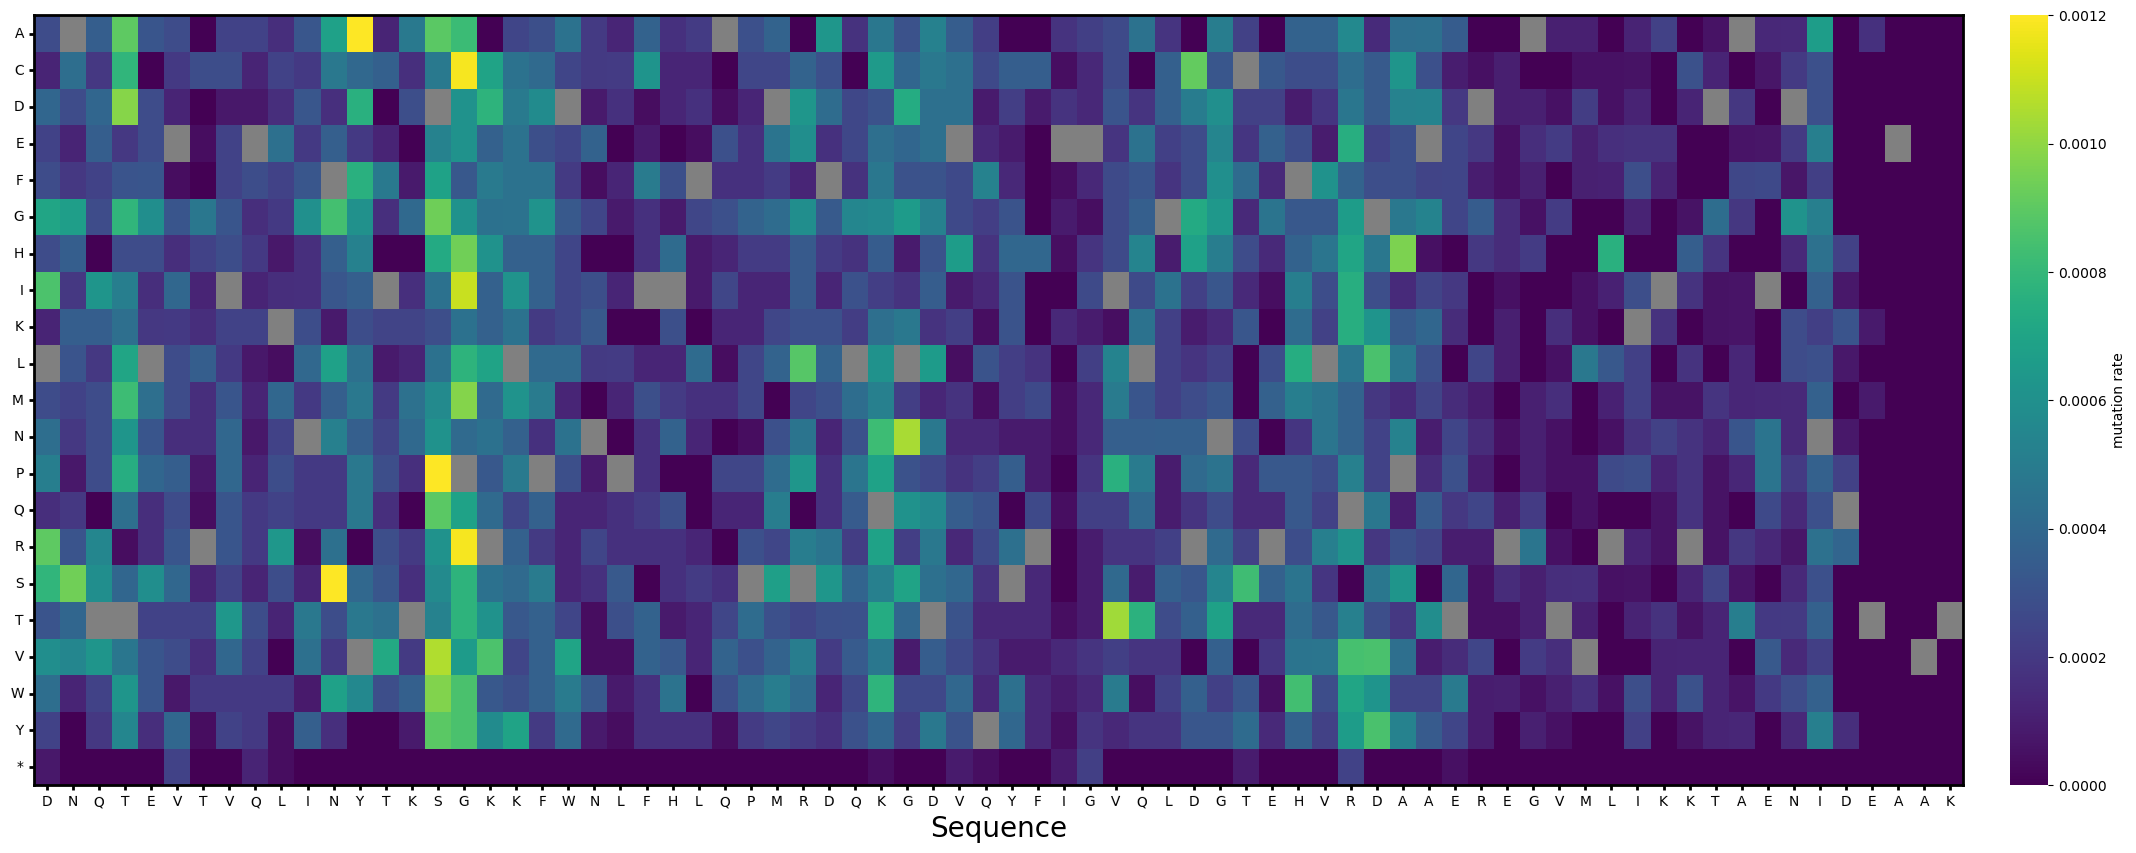

In [168]:
enrichment_df = pd.DataFrame.from_dict(enrichment)
enrichment_df = enrichment_df.loc[:,enrichment_df.sum() > 0]
enrichment_counts, enrichment_relative = mask_ref_in_variants_df(enrichment_df, LOV2_prot, data_type="AA", reverse = True if read_dir == "R2" else False)

### BC1
plot_mutation_enrichment(enrichment_relative, ref_seq=LOV2_prot[-enrichment_df.shape[1]:],vmax = 0.0012)

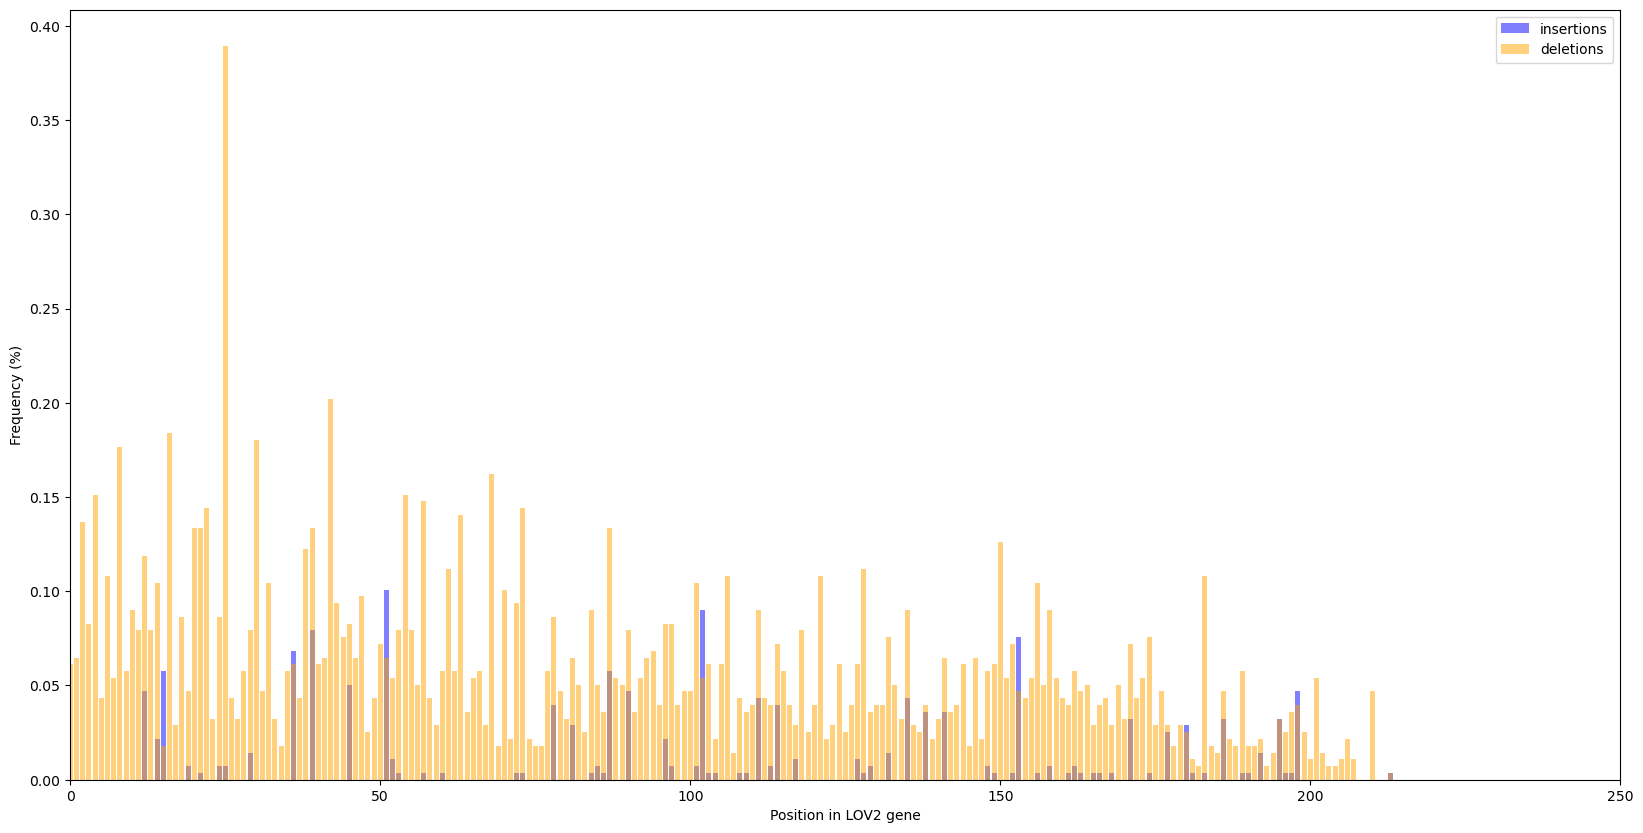

In [170]:
plt.figure(figsize=(20,10))
plt.bar(indels_freq.columns, indels_freq.loc["insertion"]*100, color = "blue", alpha = 0.5, label = "insertions")
plt.bar(indels_freq.columns, indels_freq.loc["deletion"]*100, color = "orange", alpha = 0.5, label = "deletions")
plt.legend()
plt.xlim(0,250)#200,len(LOV2_prot)*3)#
plt.ylabel("Frequency (%)")
plt.xlabel("Position in LOV2 gene")
plt.show()

<Figure size 640x480 with 0 Axes>

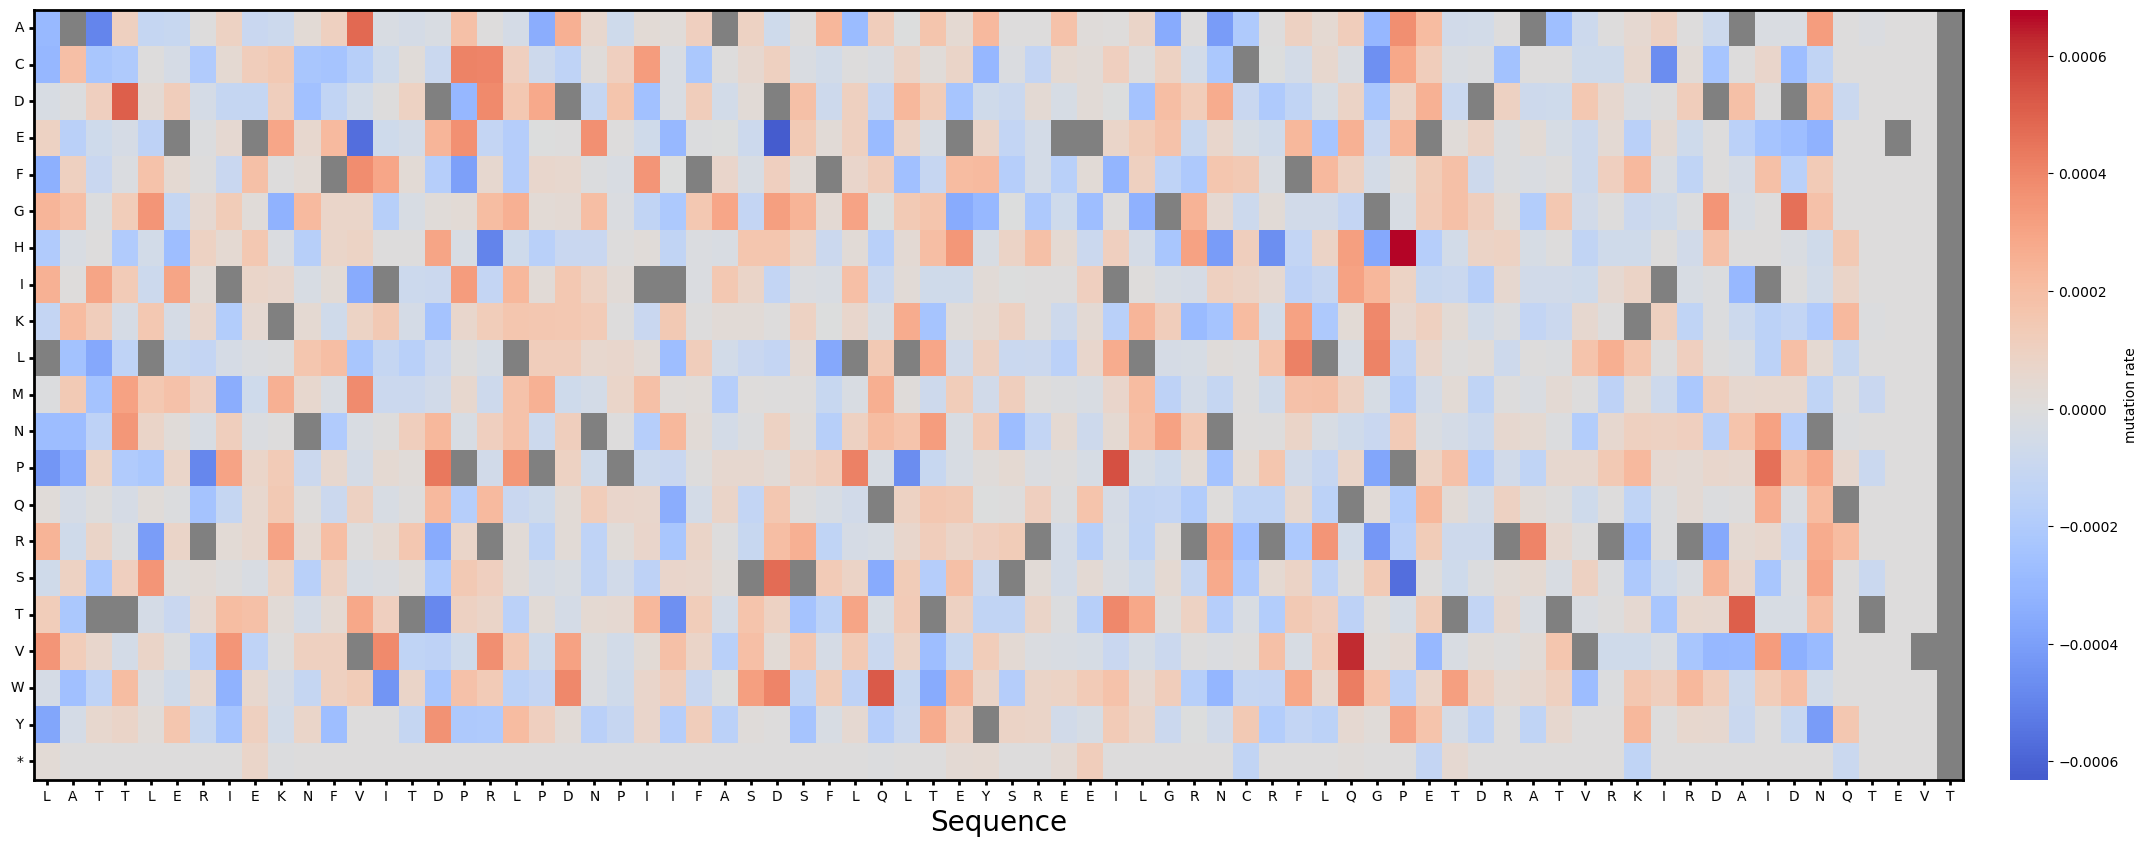

In [53]:
enrichment_relative_BC1 = enrichment_relative_1.copy()
enrichment_relative_BC2 = enrichment_relative.copy()
enrichment_BC2_vs_BC1 = enrichment_relative_BC2 - enrichment_relative_BC1

plot_mutation_enrichment(variants_df=enrichment_BC2_vs_BC1, ref_seq=LOV2_prot[:enrichment_df.shape[1]], cmap = "coolwarm")

In [171]:
frameshifts = 0
linkers = {}
wt_linker = "SG" if read_dir =="R1" else "GS"

for x in linker_alignments.values():
      qseq = x["qseq"]
      hseq = x["hseq"]

      ##### exclude frameshift reads 
      if qseq.count("-") %3 !=0 or hseq.count("-") %3 !=0: # insertions (shown as "-" in ref) not multiple of three lead to frameshifts -> exclude these reads

            frameshifts += 1

      ##### WT sequences
      elif qseq == hseq: ## WT linkers with differences in the rest of the sequence are taken into account below
                  
                  linkers["wt"] = linkers.get("wt", 0) +1

      ##### reads with deletions 
      elif hseq.count("-") > 0 and hseq.count("-") %3 == 0: ## deletions that are multiple of 3, not leading to frameshifts 

            if hseq.count("-") == 3:  #### 3 deletions represent substitution of SG linker by a single AA, here we might also get some noise, due to sequencing errors that lead to deletions of 3 Nts but this is fine (?)

                  hseq_filt = re.sub("-","", hseq) 
                  if read_dir == "R2": 
                        linker = translate_dna2aa(hseq_filt)[:len(wt_linker)-1] ## linker shortened by 3 Nts = 1 AA

                  else: 
                        linker = translate_dna2aa(hseq_filt)[-len(wt_linker)+1:] ## linker shortened by 3 Nts = 1 AA

                  linkers[linker] = linkers.get(linker, 0) +1
                  

            else: ### deletions in the linker region

                  del_count = hseq.count("-") 
                  
                  delname = "del-"+str(del_count)

                  linkers[delname] = linkers.get(delname, 0) +1

      ###### reads with substitutions 
      elif qseq.count("-") == 0: ### linker was substituted, but no deletions or insertions present

            if read_dir == "R2":
                  if hseq[:len(wt_linker)*3] == qseq[:len(wt_linker)*3]:
                        linkers["wt"] = linkers.get("wt", 0) +1
                  else: 
                        linker = translate_dna2aa(hseq)[:len(wt_linker)]
                        linkers[linker] = linkers.get(linker, 0) +1
            
            else: 
                  if hseq[-len(wt_linker)*3:] == qseq[-len(wt_linker)*3:]: ## WT linker (but differences in the rest (e.g beginning) of the sequence, thus these did not meet the first criterium)
                  
                        linkers["wt"] = linkers.get("wt", 0) +1

                  else: 
                        linker = translate_dna2aa(hseq)[-len(wt_linker):]
                        linkers[linker] = linkers.get(linker, 0) +1
      
      ###### reads with insertions
      elif qseq.count("-") > 0:

            insertion_len = qseq.count("-")//3 # AA level 
            if read_dir == "R2": 
                  linker = translate_dna2aa(hseq)[:len(wt_linker)+insertion_len]
                  linkers[linker] = linkers.get(linker, 0) +1
            
            else: 
                  linker = translate_dna2aa(hseq)[-len(wt_linker)-insertion_len:]
                  linkers[linker] = linkers.get(linker, 0) +1

      #### all other reads
      else:
            print("sequence", hseq, "does not meet any criteria")

print(frameshifts, "reads excluded due to frameshifts")

507 reads excluded due to frameshifts


In [172]:
## sort linkers by frequency

linkers_sorted = {k: v for k, v in sorted(linkers.items(), key=lambda item: item[1], reverse=True)}
total_reads = sum(linkers_sorted.values())
linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

# exclude wt: 
linkers_sorted_perc.pop("wt")
linkers_perc_filt = {k: v for k, v in linkers_sorted_perc.items() if v > 0.01}

In [173]:
sum(linkers_perc_filt.values())

17.72175125692685

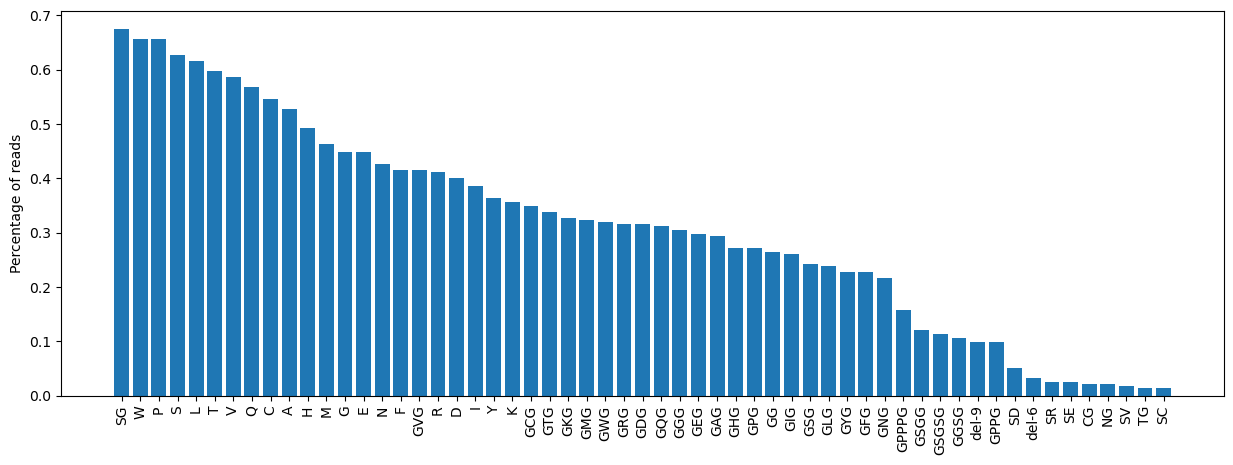

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.show()

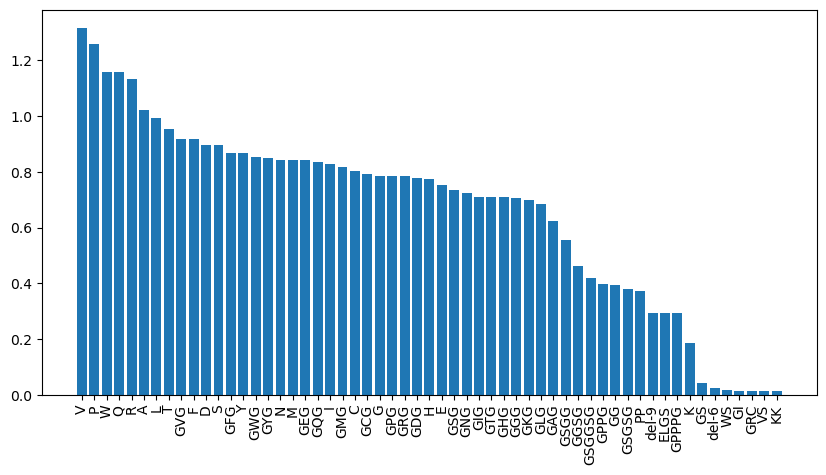

In [114]:
## BC1 -> no linker indels 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.show()